# Terrence Thesis - Recharge Boundary
***(Weekly Stress Period)***

- The time step has been changed from daily to weekly
- Implemented the recharge package in the model

### Recharge package:

1. *The infiltrated water should be unequally distributed under the basin (especially for basin 1&2). However, for recharge package, the infiltration rate was assumed the same everywhere (It is hard to define which part has higher infiltration rate in Recharge package).*


2. *Once the cells fell dry, it can be not rewet again. Thus, the fluxes to the first active layer increase the groundwater heads to unreasonable high values in that layer, Which also increases the difficulites and inaccuracies for the heat transport model*

### Import Statements

In [1]:
import flopy
import flopy.modflow as mf
import flopy.utils as fu
import flopy.utils.binaryfile as bf
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import platform
import shutil
import sys
import datetime
import math
from sklearn.metrics import mean_squared_error as mse
import flopy.mt3d as mt3
from flopy.export import vtk
%matplotlib inline

### Setup folder where modflow-files are located

In [2]:
workspace = os.path.join('mf-data-weekly-rch')

In [3]:
if os.path.exists(workspace):
    shutil.rmtree(workspace)

if not os.path.exists(workspace):
    os.makedirs(workspace)

### Print versions

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.14.3
matplotlib version: 2.1.1
flopy version: 3.2.10


### Setup MF-Package

In [5]:
modelname = 'model'
exe_name = 'mf2005'

if platform.system() == 'Windows':
    exe_name += '.exe'

In [6]:
tm = mf.Modflow(modelname=modelname, exe_name=exe_name, version='mf2005', model_ws=workspace)

### Setup Discretization Package

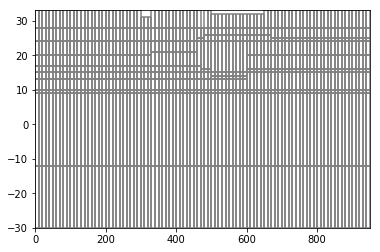

In [7]:
nrow = 1
ncol = 95
nlay = 10

Lx = 950
Ly = 1

botm = np.ones ( (nlay, nrow, ncol), dtype=np.int32 )
top = 33 * np.ones ( (nrow, ncol), dtype=np.int32 )

# Range does not include upper bound !!!
for i in range ( 30, 33):
    top[ :, i ] = 31
for i in range ( 47, 48 ):
    top[ :, i ] = 28
for i in range ( 50, 65):
    top[ :, i ] = 32

# N1 layer
botm[ 0, :, : ] = 28

# N2 layer46 
for i in range ( 0, 46):
    botm[ 1, :, i ] = 24
for i in range ( 46, 48 ):
    botm[ 1, :, i ] = 25
for i in range ( 48, 67 ):
    botm[ 1, :, i ] = 26
for i in range ( 67, ncol ):
    botm[ 1, :, i ] = 25
# N3 layer
for i in range ( 0, 33 ):
    botm[ 2, :, i ] = 20
for i in range ( 33, 46 ):
    botm[ 2, :, i ] = 21.5
for i in range ( 46, 48 ):
    botm[ 2, :, i ] = 24
for i in range ( 48, ncol ):
    botm[ 2, :, i ] = 24.5
# N4 layer
for i in range ( 0, 47 ):
    botm[ 3, :, i ] = 17
for i in range ( 47, 50 ):
    botm[ 3, :, i ] = 16
for i in range ( 50, 60 ):
    botm[ 3, :, i ] = 15
for i in range ( 60, ncol ):
    botm[ 3, :, i ] = 20
# N5 layer
for i in range ( 0, 50 ):
    botm[ 4, :, i ] = 15
for i in range ( 50, 60 ):
    botm[ 4, :, i ] = 14
for i in range ( 60, ncol ):
    botm[ 4, :, i ] = 16
# N6 layer
for i in range ( 0, 60 ):
    botm[ 5, :, i ] = 13
for i in range ( 60, ncol ):
    botm[ 5, :, i ] = 15
# 7 layer
botm[ 6, :, : ] = 10
# 8 layer
botm[ 7, :, : ] = 9
# 9 layer
botm[ 8, :, : ] = -12.5
# 10 layer
botm[ 9, :, : ] = -30

delr = Lx / ncol
delc = Ly / nrow
nper = 505

perlen = np.ones ( nper) * 7
perlen[0] = 1
#nstp = np.ones ( nper) * 7
#nstp[0] = 1
#print(perlen)
steady = np.full ( nper, False, dtype=bool )
steady[ 0 ] = True
dis = mf.ModflowDis(
    tm, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper,
    perlen = perlen,
    steady=steady,
    lenuni = 2,
    xul = 781658.203,#375003.097,
    yul = 5831682.381,#6902348.682,
    proj4_str = "EPSG:32632",
    start_datetime = '11/05/2005'
)

modelxsect= flopy.plot.ModelCrossSection(model=tm, line={'Row':0})
linecollection= modelxsect.plot_grid()

### Setup Basic-Package

Specify boundary conditions and starting heads.

We can set one value for all cells.

In [8]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

for i in range ( 1, nlay ):
    ibound[ i, :, 0 ] = -1
    ibound[ i, :, -1 ] = -1

for k in range ( 47, 49 ):
    ibound[ 0, :, k ] = 0

strt = np.ones ( (nlay, nrow, ncol), dtype=np.int32 ) * 28
#strt[ 1, :, 1 ] = 28 
#strt[ 1, :, -1 ] = 28

for i in range ( 30, 33 ):
    strt[ 0, :, i ] = 29
for j in range ( 50, 65 ):
    strt[ 0, :, j ] = 29
    
bas = mf.ModflowBas(tm, ibound=ibound, strt=strt)

#bas.plot()

### Setup Constant Head Boundaries

In [9]:
csv = pd.read_csv('SPA101-weekly.csv', delimiter=' ')
chd_values = csv.iloc[ :, 1 ].values

#chd for each cell
#[lay, row, col, shead, ehead]
spchd = {}
spchd[0] = [
    [1, 0, 0, 28, 28 ], 
    [1, 0, ncol-1, 28, 28 ]
]

for layer in range (2, nlay):
    spchd[0].append ([layer, 0, 0, 28, 28 ])

for stress_period in range ( 1, nper ):
    spchd[stress_period] = [[1, 0, 0, chd_values[stress_period - 1], chd_values[stress_period]]]
    for layer in range (2, nlay):
        spchd[stress_period].append ([layer, 0, 0, chd_values[stress_period-1], chd_values[stress_period]])

chd = mf.ModflowChd(tm, stress_period_data=spchd)
#chd.plot()

### Setup Recharge Boundaries

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
{0: [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])], 1: [array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 2.02, 2.02, 2.02,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.36, 0.36, 0.36, 0.36, 0.36,
        0.36, 0.36, 0.36,

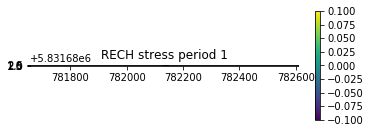

In [10]:
sp = {}
sp[0] = []
bas12_data = pd.read_csv ( 'Basin1&2-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values
bas3_data = pd.read_csv ( 'Basin3-weekly.csv', delimiter=' ' ).iloc[ :, 1 ].values

rch1 = np.zeros((nrow, ncol, nper))
print (rch1)
x = bas12_data 
y = bas3_data
rech = {}
rech[0] = [np.zeros((nrow, ncol))]
for i in range(1,nper):
    rech[i] = []
    for j in range(30,33):
        if rch1[:,j,i] > 3:
            rch1[:,j,i] = 3
        else:
            rch1[:,j,i] = y[i-1]
    for z in range(50,65):
        if x[i-1] > 0.5:
            rch1[:,z,i]= 0.5
        else:
            rch1[:,z,i] = x[i-1]
    rech[i].append (rch1[:,:,i])
        
print (rech)
rch = mf.ModflowRch ( tm, nrchop=3, rech = rech )
rch.plot()

### Setup Wells

In [11]:
# Pumping Well
wel_data = pd.read_csv('Pumping_well-weekly.csv', delimiter=' ').iloc[:, -2].values 

# -1 pumping rate of well 6
# -2 average pumping rate of well 5 and well 6

spwell = {}
spwell[0] = [8, 0, 41, 0]
for i in range(1, nper):
    spwell[i] = [8, 0, 41, -wel_data[i-1]/35]
    
wel = mf.ModflowWel(tm, stress_period_data=spwell, ipakcb=53)

#wel.plot()

### Setup Soil properties and Flow-Package

In [12]:
k1 = 6   # fine sand 1.728-7.776
k2 = 16  # middle sand 7.776-34.56
k3 = 39  # stone 34.56-103.68
k4 = 1   # clay
k5 = 16  # middle sand2
k6 = 6   # fine sand 1.728-7.776

# Set default hk-value value to k2
hk = np.ones((nlay, nrow, ncol)) * k2

# N1 layer
hk[0, :, :] = k1  # fine sand

# N2 layer
hk[1, :, :] = k2  # middle sand

# N3 layer
for i in range( 30, 60 ):
    hk[2, :, i] = k3  # sand & stone
for i in range( 55, 67 ):
    hk[2, :, i] = k4  # clay

#  N4 layer
hk[3, :, :] = k5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 44, 48 ):
    hk[4, :, i] = k4  # clay
for i in range( 48, 60 ):
    hk[4, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[4, :, i] = k4  # clay

# N6 layer
hk[5, :, :] = k3
for i in range(36, 50 ):
    hk[5, :, i] = k6  # fine sand
for i in range( 50, 60 ):
    hk[5, :, i] = k3  # sand & stone
for i in range( 60, 65 ):
    hk[5, :, i] = k4  # clay

# 7 layer
hk[6, :, :] = k5  # middle sand2

# 8 layer
hk[7, :, :] = k5
for i in range(36 , 50 ):
    hk[7, :, i] = k6  # fine sand

# 9 layer
hk[8, :, :] = k5  # middle sand2

# 10 layer
hk[9, :, :] = k5  # middle sand2


# vertical HK
vk1 = k1*0.3#2 #2
vk2 = k2*0.3#6 #6
vk3 = k3*0.3#10 #10
vk4 = k4*0.3#0.5 #0.5
vk5 = k5*0.3#6 #6
vk6 = k6*0.3#2 #2

vka = np.ones((nlay, nrow, ncol)) * vk2

# N1 layer
vka[0, :, :] = vk1  # fine sand


# N2 layer
vka[1, :, :] = vk2  # middle sand

# N3 layer
vka[2, :, :] = vk3
for i in range( 30, 55 ):
    vka[2, :, i] = vk3  # sand & stone
for i in range( 55, 67 ):
    vka[2, :, i] = vk4  # clay

# N4 layer
vka[3, :, :] = vk5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 44, 48 ):
    vka[4, :, i] = vk4  # clay
for i in range( 48, 60 ):
    vka[4, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[4, :, i] = vk4  # clay

# N6 layer
vka[5, :, :] = vk3
for i in range( 36, 50 ):
    vka[5, :, i] = vk6  # fine sand
for i in range( 50, 60 ):
    vka[5, :, i] = vk3  # sand & stone
for i in range( 60, 65 ):
    vka[5, :, i] = vk4  # clay

# N7 layer
vka[6, :, :] = vk5  # middle sand2

# N8 layer
vka[7, :, :] = vk5
for i in range( 36, 50):
    vka[7, :, i] = vk6  # fine sand

# N9 layer
vka[8, :, :] = vk5  # middle sand2

# N10 layer
vka[9, :, :] = vk5  # middle sand2

laytyp = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# Specific yield 
sy1 = 0.25 # fine sand 
sy2 = 0.30 # middle sand
sy3 = 0.30 # stone 
sy4 = 0.16 # clay
sy5 = 0.30 # middle sand
sy6 = 0.25 # fine sand 

sy = np.ones((nlay, nrow, ncol)) * sy2

# N1 layer
sy[0, :, :] = sy1  # fine sand


# N2 layer
sy[1, :, :] = sy2  # middle sand

# N3 layer
sy[2, :, :] = sy3
for i in range( 30, 55 ):
    sy[2, :, i] = sy3  # sand & stone
for i in range( 55, 67 ):
    sy[2, :, i] = sy4  # clay

# N4 layer
sy[3, :, :] = sy5  # middle sand2

# N5 layer
for i in range( 30, 44 ):
    sy[4, :, i] = sy3  # sand & stone
for i in range( 44, 48 ):
    sy[4, :, i] = sy4  # clay
for i in range( 48, 60 ):
    sy[4, :, i] = sy3  # sand & stone
for i in range( 60, 65 ):
    sy[4, :, i] = sy4  # clay

# N6 layer
sy[5, :, :] = sy3
for i in range( 36, 50 ):
    sy[5, :, i] = sy6  # fine sand
for i in range( 50, 60 ):
    sy[5, :, i] = sy3  # sand & stone
for i in range( 60, 65 ):
    sy[5, :, i] = sy4  # clay

# N7 layer
sy[6, :, :] = sy5  # middle sand2

# N8 layer
sy[7, :, :] = sy5
for i in range( 36, 50):
    sy[7, :, i] = sy6  # fine sand

# N9 layer
sy[8, :, :] = sy5  # middle sand2

# N10 layer
sy[9, :, :] = sy5  # middle sand2


ss = 1e-5

lpf = mf.ModflowLpf(tm, laytyp=laytyp, hk=hk, layvka=0, vka=vka, sy=sy, ss=ss, ipakcb=53)

#lpf.plot()

### Setup Solver Package and Output-control with defaults

In [13]:
budgetfile = '{}.cbc'.format(modelname)
budget_filerecord = [budgetfile]
oc = mf.ModflowOc(tm, 
                   save_every=True,
                   save_types=[ 'save head', 'save budget'],
                   budget_filerecord=budget_filerecord,
                   compact=True
                  )


pcg = mf.ModflowPcg (tm, rclose=1e-1)

lmt = flopy.modflow.ModflowLmt ( tm, output_file_name = modelname + '.ftl', output_file_header='extended',
                                 output_file_format='formatted')

### Write Model input and run the model

In [14]:
tm.write_input()
success = tm.run_model()#silent = True)
cbc = bf.CellBudgetFile(os.path.join(workspace, modelname + '.cbc'))
flopy.export.shapefile_utils.model_attributes_to_shapefile('model.shp', tm, package_names = ['dis'])

FloPy is using the following  executable to run the model: C:\modflow\Packages\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/11/07 11:20:48

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Gr

 Solving:  Stress period:   124    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:     1    Ground-Wa

 Solving:  Stress period:   232    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:     1    Ground-Wa

 Solving:  Stress period:   341    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:     1    Ground-Wa

 Solving:  Stress period:   447    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   448    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   449    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   450    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   451    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   452    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   453    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   454    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   455    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   456    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   457    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   458    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   459    Time step:     1    Ground-Wa

### Read and Plot Head Observations

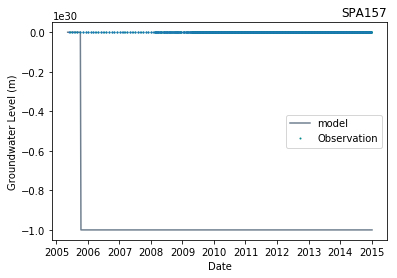

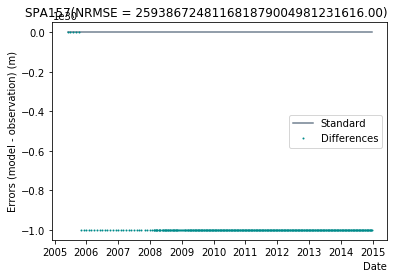

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


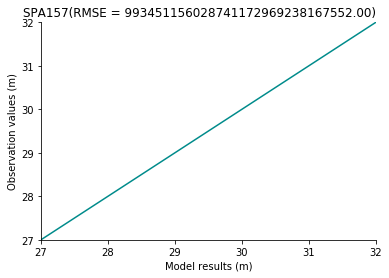

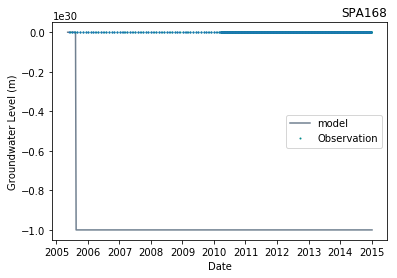

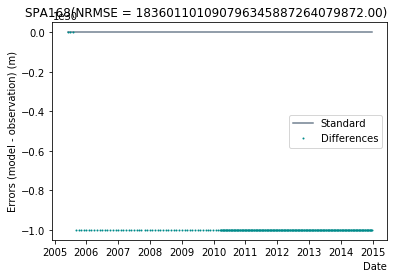

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


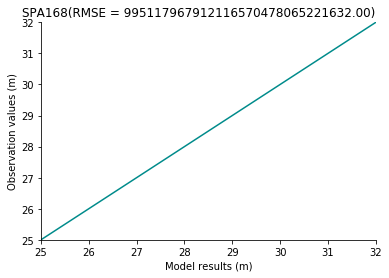

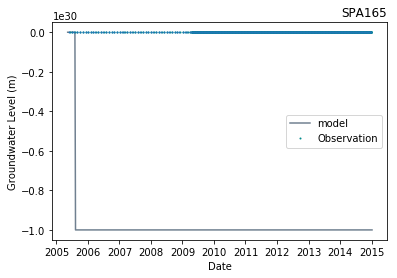

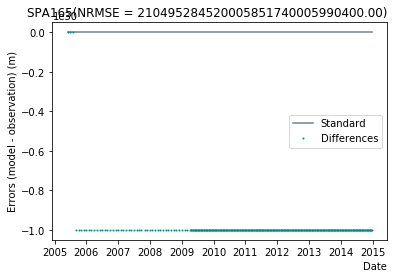

c:\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


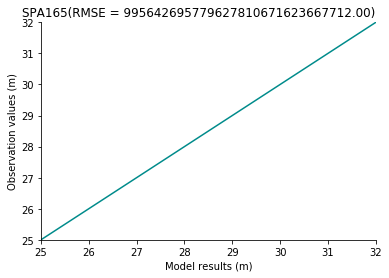

In [15]:
headobj = bf.HeadFile(os.path.join(workspace, modelname + '.hds'))

#observation wells

obs = [(1, 0, 65),
       (1, 0, 48),
       (1, 0, 46)]
name = ['SPA157','SPA168','SPA165']

for j in range (0,3):
    ts = headobj.get_ts ( idx= obs[j] )
    np.savetxt ( "HD.csv", ts, delimiter=',', header='Days,Head' )
    model = pd.read_csv ( 'HD.csv',delimiter=',')
    date = []
    for d in model['# Days']:
        date.append(datetime.datetime(2005,5,11)+datetime.timedelta(d-1)) 
    model['date'] = date
    model['nweek'] = np.int64((model['# Days']-1)/7+1)

    observation = pd.read_csv ( name[j]+'.csv' , delimiter=',' )
    date = []
    for d in observation['# Days']:
        date.append(datetime.datetime(2005,5,11)+datetime.timedelta(d-1)) 
    observation['date'] = date
   
    
    observation1 = pd.read_csv ( name[j]+'-weekly.csv' , delimiter=' ', header = -1)
    date = []
    for d in observation1.iloc[:,0]:
        date.append(datetime.datetime(2005,5,11)+datetime.timedelta((d-1)*7)) 
    observation1['date'] = date    
    #observation1['nweek'] = observation1.iloc[:,0]
    observation1.columns = ['nweek','Head','date']

    #print(observation1)
    plt.plot ( model['date'], model.iloc[:,1], label='model' , c = 'slategray')
    plt.plot( observation['date'], observation.iloc[:,1], '.', label='Observation', markersize = 2,c='darkcyan' )
    plt.plot( observation1['date'], observation1.iloc[:,1], '.', label='Observation1', markersize = 2 )
    plt.legend ( [ "model", "Observation" ] )
    plt.xlabel ( 'Date' )
    plt.ylabel ( 'Groundwater Level (m)' )
    plt.title ( name[j] , loc='right' )
    plt.show ()
    
    merge = pd.merge ( model, observation1,left_on='date',right_on='date',how='inner')
    merge = merge.iloc[:,[2,1,-1]]
    merge.columns = ['date','Head_model','Head_obs']
    
    h1 = merge['Head_model']
    h2 = merge['Head_obs']
    rmse = math.sqrt ( mse ( h1, h2 ) )
    nrmse = rmse/(np.max(h2)-np.min(h2))
    rmse = '{:01.2f}'.format(rmse)
    nrmse = '{:01.2f}'.format(nrmse)
    u = []
    u = h1-h2
    a = h1 - h1
    plt.plot(merge['date'],a,c='slategray',label='Standard')
    plt.plot(merge['date'],u,'.',label='Differences',markersize = 2,c = 'darkcyan')
    plt.legend(['Standard','Differences'])
    plt.xlabel('Date',horizontalalignment='right',x=1.0)
    plt.ylabel('Errors (model - observation) (m)')
    plt.title( name[j] + '(NRMSE = ' + str ( nrmse )+')', loc='right')
    plt.show()
    
    x = [int(min(h2)),32]
    y = [int(min(h2)),32]
    plt.scatter(h1,h2,s = 5,c='slategray')
    plt.plot(x,y,c='darkcyan')
    plt.ylim(int(min(h2)),32)
    plt.xlim(int(min(h2)),32)
    plt.xlabel('Model results (m)')
    plt.ylabel('Observation values (m)')
    plt.subplot().spines['right'].set_color('none')
    plt.subplot().spines['top'].set_color('none')
    plt.subplot()
    plt.title(name[j] + '(RMSE = ' + str ( rmse )+')', loc='right')
    plt.show()
    
    os.remove('HD.csv')
